In [3]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [4]:

X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/X.txt',index_col=None,delim_whitespace=True,header=None)

print(X_all)

          0       1       2       3       4       5       6       7       8
0    3.0312  1.0938  3.0312  1.0938  3.0312  0.5300  4.1875  0.0013  0.5750
1    1.0938  3.0312  1.0938  3.0312  1.0938  1.3300  2.5625  0.0038  0.8250
2    3.5156  3.5156  0.6094  2.5469  1.5781  0.7300  3.7812  0.0007  0.7625
3    2.5469  0.6094  1.5781  1.5781  0.6094  1.1300  4.5938  0.0044  0.6375
4    0.6094  2.5469  3.5156  3.5156  2.5469  0.3300  2.9688  0.0019  0.8875
..      ...     ...     ...     ...     ...     ...     ...     ...     ...
595  3.8258  1.1949  2.5839  1.5361  1.7490  1.2648  1.9358  0.0030  0.8598
596  2.6710  0.6642  0.9547  0.9580  0.6480  1.3265  2.2269  0.0042  0.5731
597  2.2590  0.7444  1.9865  1.1162  1.2837  1.1592  2.1746  0.0033  0.7042
598  3.6389  0.7623  2.8345  0.5306  2.8174  1.0744  2.3327  0.0035  0.8081
599  2.4254  0.5653  2.2130  0.8944  3.5599  0.9967  1.9030  0.0047  0.5225

[600 rows x 9 columns]


In [5]:

y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/Y.txt',index_col=None,delim_whitespace=True,header=None)

print(y_all)

          0       1       2       3       4       5        6
0    4.8305  3.8516  6.9308  4.9914  7.3701  2.7390  96.8291
1    4.4470  2.9320  6.5672  5.1431  6.8284  3.0203  82.9983
2    5.0224  3.7737  6.7237  5.4473  7.5285  3.5713  92.7497
3    5.0951  4.1124  6.8647  5.8018  7.2604  2.9882  94.1621
4    6.4672  5.0741  8.3397  7.3326  8.2225  5.3466  99.6714
..      ...     ...     ...     ...     ...     ...      ...
595  3.8059  3.2104  5.1902  4.3614  5.5339  1.7484  78.3615
596  3.6194  3.2834  4.7544  3.7607  5.5069  1.5465  83.0262
597  3.6959  3.2189  5.0969  3.9837  5.6779  1.4518  83.7040
598  3.5749  3.3218  4.6965  4.3147  5.1181  0.9455  84.9504
599  3.5916  3.1638  4.9931  3.9763  5.5175  1.1779  80.9421

[600 rows x 7 columns]


# Emulator

NameError: name 'x_labels' is not defined

In [8]:
y_train = torch.tensor(y_all.values[0:200])
x_train = torch.tensor(X_all.values[0:200])

In [9]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6


In [10]:
y_train[100]

tensor([ 4.3384,  2.7007,  6.7765,  5.3975,  5.8045,  3.3102, 79.3666],
       dtype=torch.float64)

In [11]:
nDim = X_all.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_all.iloc[:,i]),np.max(X_all.iloc[:,i])])
    print(boundsMaxMin[i])

[0.1553, 3.9924]
[0.1704, 3.9546]
[0.2385, 3.9924]
[0.1553, 3.9773]
[0.1704, 3.9849]
[0.1362, 1.7175]
[1.7627, 4.9937]
[0.0001, 0.005]
[0.4539, 0.948]


In [12]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [13]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.000000001*np.identity(ndim), size=(nwalkers))
y_val = y_train[100]

In [14]:
boundsMaxMin

[[0.1553, 3.9924],
 [0.1704, 3.9546],
 [0.2385, 3.9924],
 [0.1553, 3.9773],
 [0.1704, 3.9849],
 [0.1362, 1.7175],
 [1.7627, 4.9937],
 [0.0001, 0.005],
 [0.4539, 0.948]]

In [15]:
np.array(boundsMaxMin)[:,0]*2

array([3.1060e-01, 3.4080e-01, 4.7700e-01, 3.1060e-01, 3.4080e-01,
       2.7240e-01, 3.5254e+00, 2.0000e-04, 9.0780e-01])

In [16]:
p0[0]

array([2.07383754e+00, 2.06246790e+00, 2.11542055e+00, 2.06629010e+00,
       2.07765923e+00, 9.26885982e-01, 3.37815909e+00, 2.56951484e-03,
       7.00965349e-01])

In [17]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [18]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [19]:
x=torch.tensor(p0[0])[None]
ll =np.sum(emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],torch.ones(9)*0.01).detach().numpy())

In [20]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.01,0.01,0.01,0.01,0.01,0.01,0.01,1e-6,0.01])).detach().numpy())
    return ll

In [21]:
log_likelihood(p0[1],emulator,y_val)

-13.715871

In [22]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [23]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [24]:
p0[i].shape

(9,)

In [25]:
torch.tensor(p0[0]).shape

torch.Size([9])

In [26]:
emulator.predict(torch.tensor(p0)).shape

torch.Size([18, 7])

In [27]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-13.702783584594727
-13.71587085723877
-13.715790748596191
-13.703826904296875
-13.69732666015625
-13.698386192321777
-13.71813678741455
-13.72895336151123
-13.713635444641113
-13.72970962524414
-13.732136726379395
-13.708966255187988
-13.6942138671875
-13.717498779296875
-13.699642181396484
-13.715221405029297


In [28]:
import scipy

In [29]:
def neg_log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],[0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])).detach().numpy())
    return -ll

In [30]:
bds=np.array(boundsMaxMin)

In [31]:
result = scipy.optimize.minimize(neg_log_likelihood, p0[0], args=(emulator,y_val), method='Nelder-Mead', tol=1e-8,bounds=bds)


In [32]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.5670928955078125
             x: [ 7.201e-01  3.953e+00  3.375e+00  1.504e+00  3.309e+00
                  1.542e+00  2.951e+00  2.356e-03  9.480e-01]
           nit: 930
          nfev: 1521
 final_simplex: (array([[ 7.201e-01,  3.953e+00, ...,  2.356e-03,
                         9.480e-01],
                       [ 7.201e-01,  3.953e+00, ...,  2.356e-03,
                         9.480e-01],
                       ...,
                       [ 7.201e-01,  3.953e+00, ...,  2.356e-03,
                         9.480e-01],
                       [ 7.201e-01,  3.953e+00, ...,  2.356e-03,
                         9.480e-01]]), array([ 3.567e+00,  3.567e+00,  3.567e+00,  3.567e+00,
                        3.567e+00,  3.567e+00,  3.567e+00,  3.567e+00,
                        3.567e+00,  3.567e+00]))

In [33]:
result.x

array([7.20091426e-01, 3.95301746e+00, 3.37518257e+00, 1.50431040e+00,
       3.30912367e+00, 1.54197955e+00, 2.95132591e+00, 2.35625325e-03,
       9.48000000e-01])

In [34]:
log_likelihood(p0[1],emulator,y_val)

-13.715871

In [35]:
sampler.run_mcmc(p0, 80000)

State([[1.17518079e+00 2.93144196e+00 7.59039521e-01 1.78674876e+00
  1.27433155e+00 1.64682371e+00 3.12075969e+00 3.97703635e-03
  6.69818061e-01]
 [2.10136941e-01 2.64279365e+00 2.82738093e+00 1.50834564e+00
  1.72528178e+00 1.48550194e+00 2.18584124e+00 4.33967146e-03
  8.57895768e-01]
 [1.11611927e+00 2.54470032e-01 3.46728459e+00 3.62915710e+00
  2.05280253e+00 1.34399291e+00 1.94215930e+00 4.56671749e-03
  7.94481869e-01]
 [1.36139193e+00 3.39709688e+00 3.09299535e+00 2.48688589e+00
  5.29081080e-01 1.55345502e+00 1.97105861e+00 4.49064209e-03
  8.38507513e-01]
 [1.58099789e+00 2.03074714e+00 1.23036451e+00 7.99532233e-01
  2.40677944e-01 1.59064927e+00 2.68862445e+00 3.28224237e-03
  8.18513904e-01]
 [5.70189011e-01 3.41650287e+00 3.76083908e+00 5.36649735e-01
  2.29762998e+00 1.69381870e+00 3.01765338e+00 4.02439156e-03
  9.46807346e-01]
 [2.94165728e+00 6.20008994e-01 3.95551327e+00 1.74204874e+00
  4.79468923e-01 1.68476105e+00 2.54561667e+00 3.91957592e-03
  6.04006549e-01]


In [36]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(108000, 9)


In [37]:
y_val

tensor([ 4.3384,  2.7007,  6.7765,  5.3975,  5.8045,  3.3102, 79.3666],
       dtype=torch.float64)

In [40]:
result.x

array([7.20091426e-01, 3.95301746e+00, 3.37518257e+00, 1.50431040e+00,
       3.30912367e+00, 1.54197955e+00, 2.95132591e+00, 2.35625325e-03,
       9.48000000e-01])

In [41]:
x_train[100]

tensor([5.9420e-01, 3.5308e+00, 3.5913e+00, 9.2720e-01, 3.8032e+00, 1.5238e+00,
        2.6006e+00, 1.3000e-03, 9.4800e-01], dtype=torch.float64)

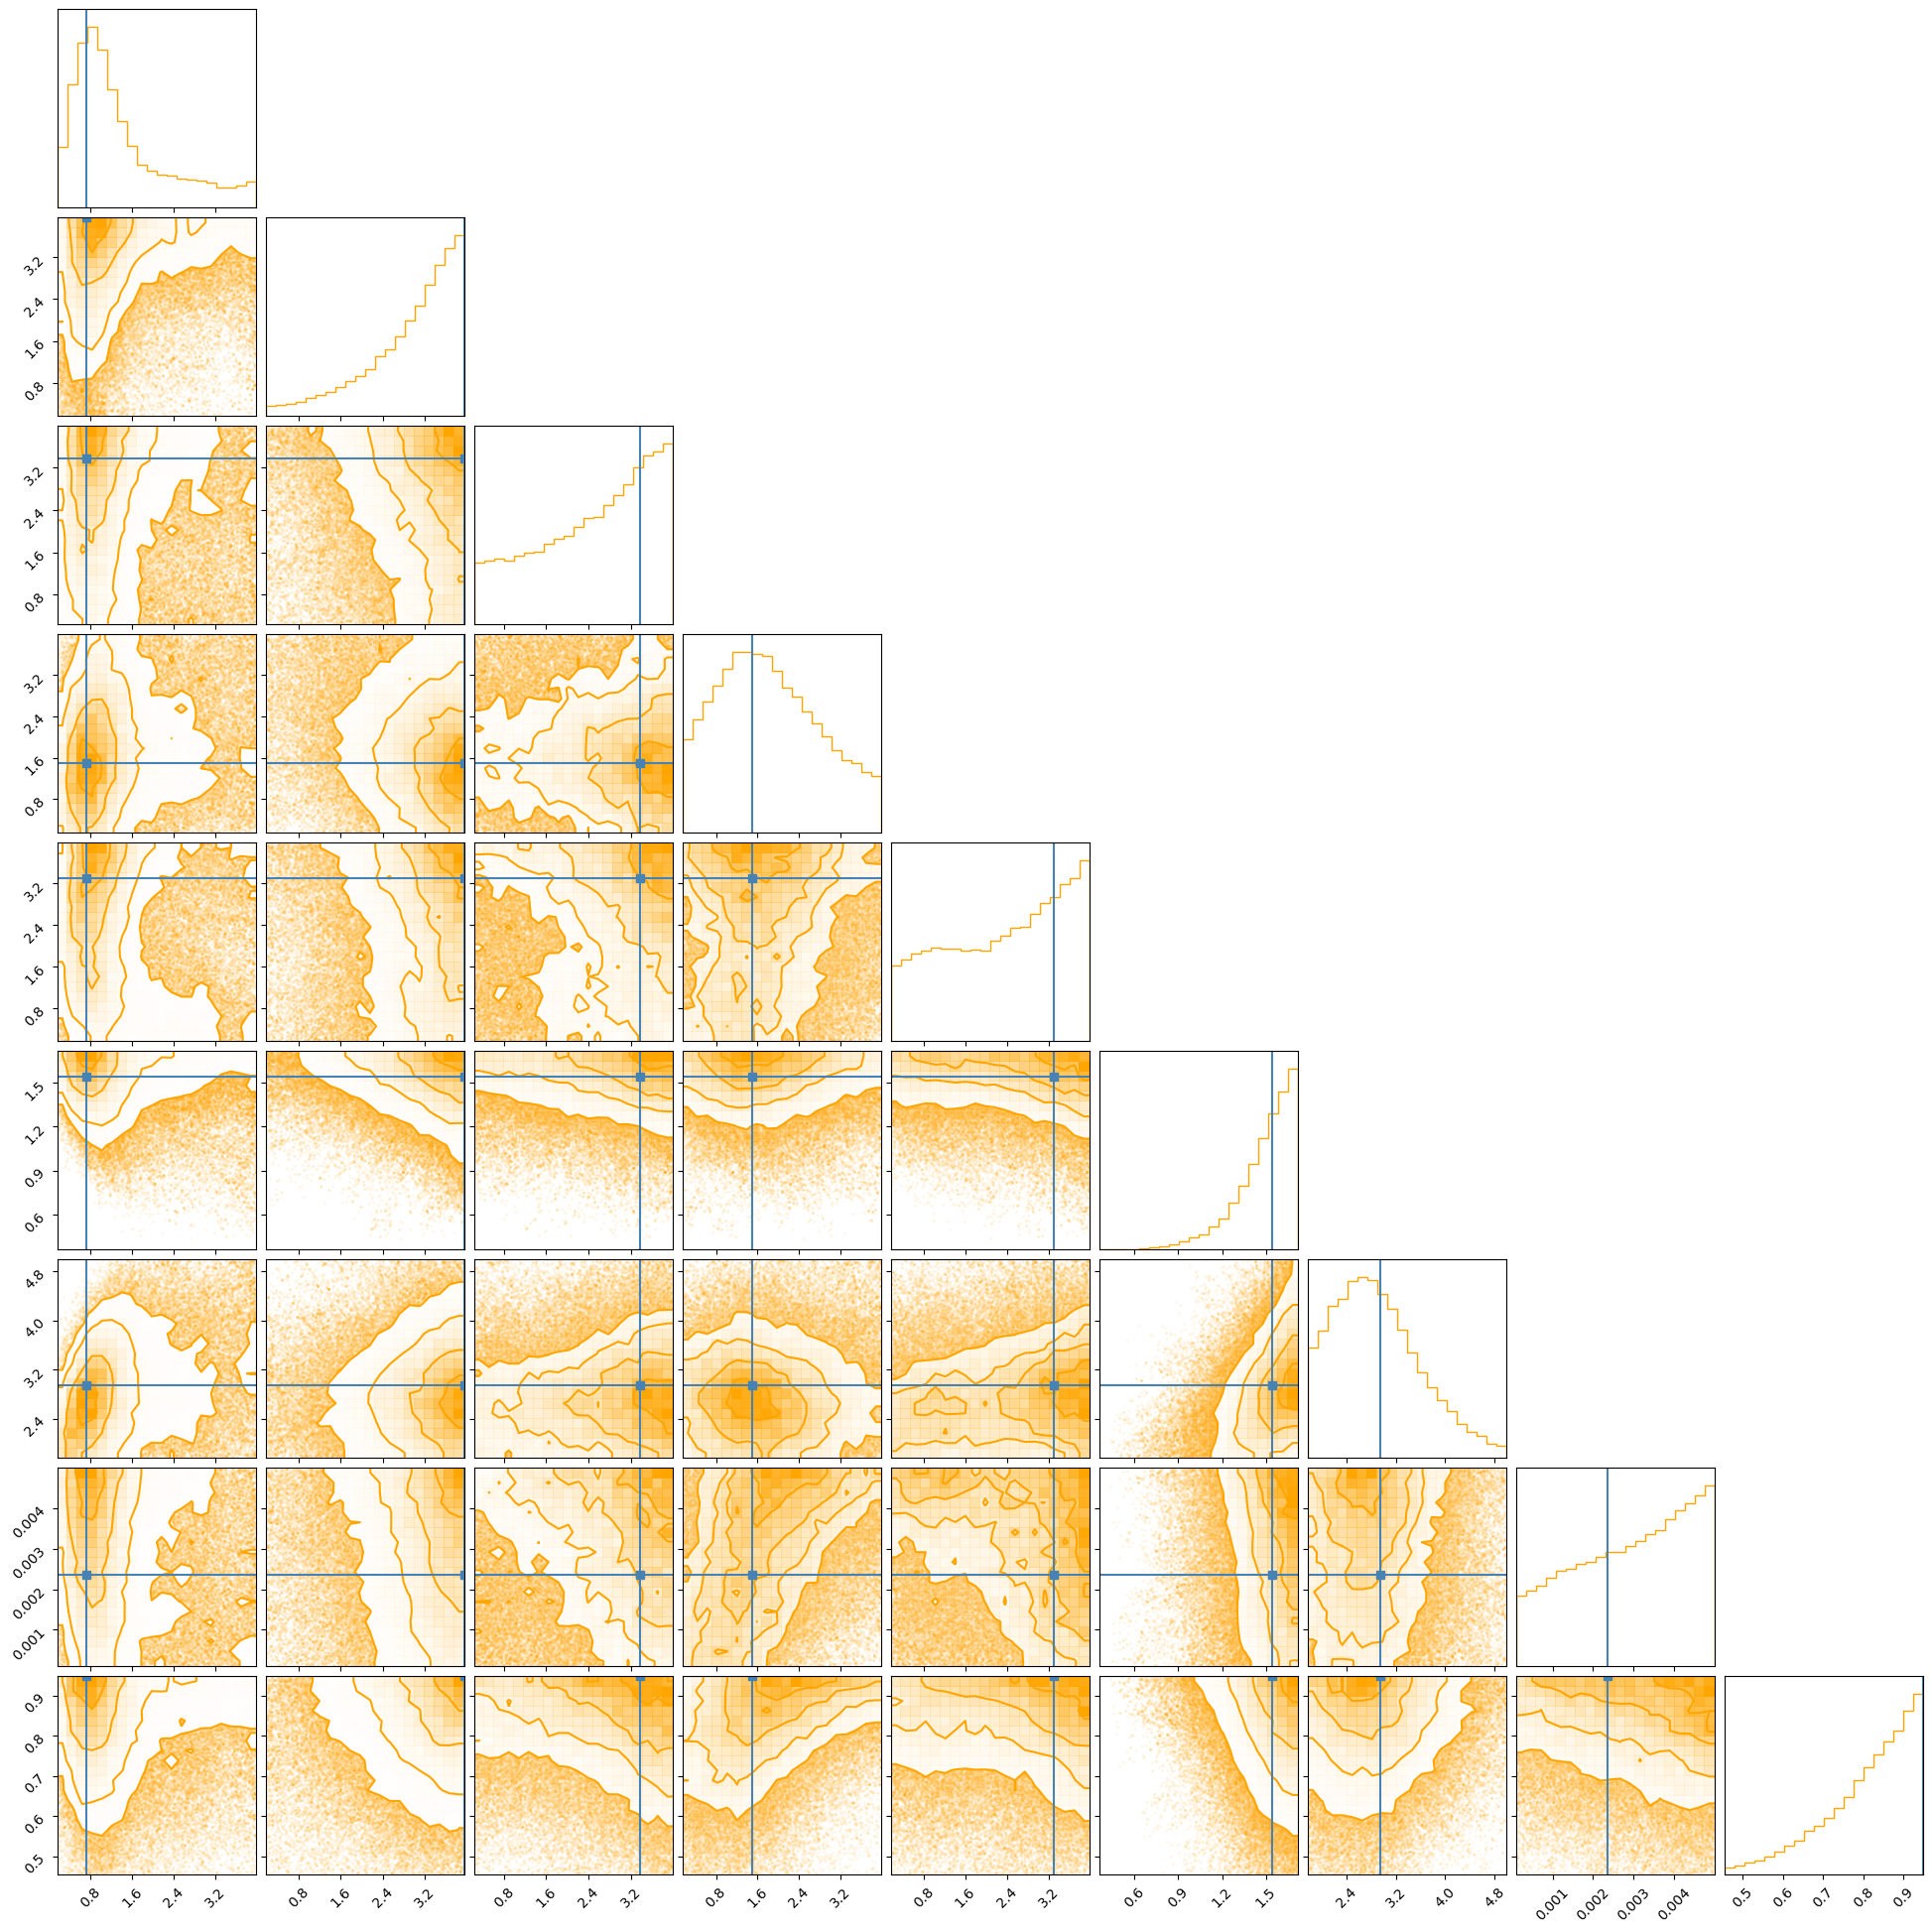

In [38]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=result.x
);

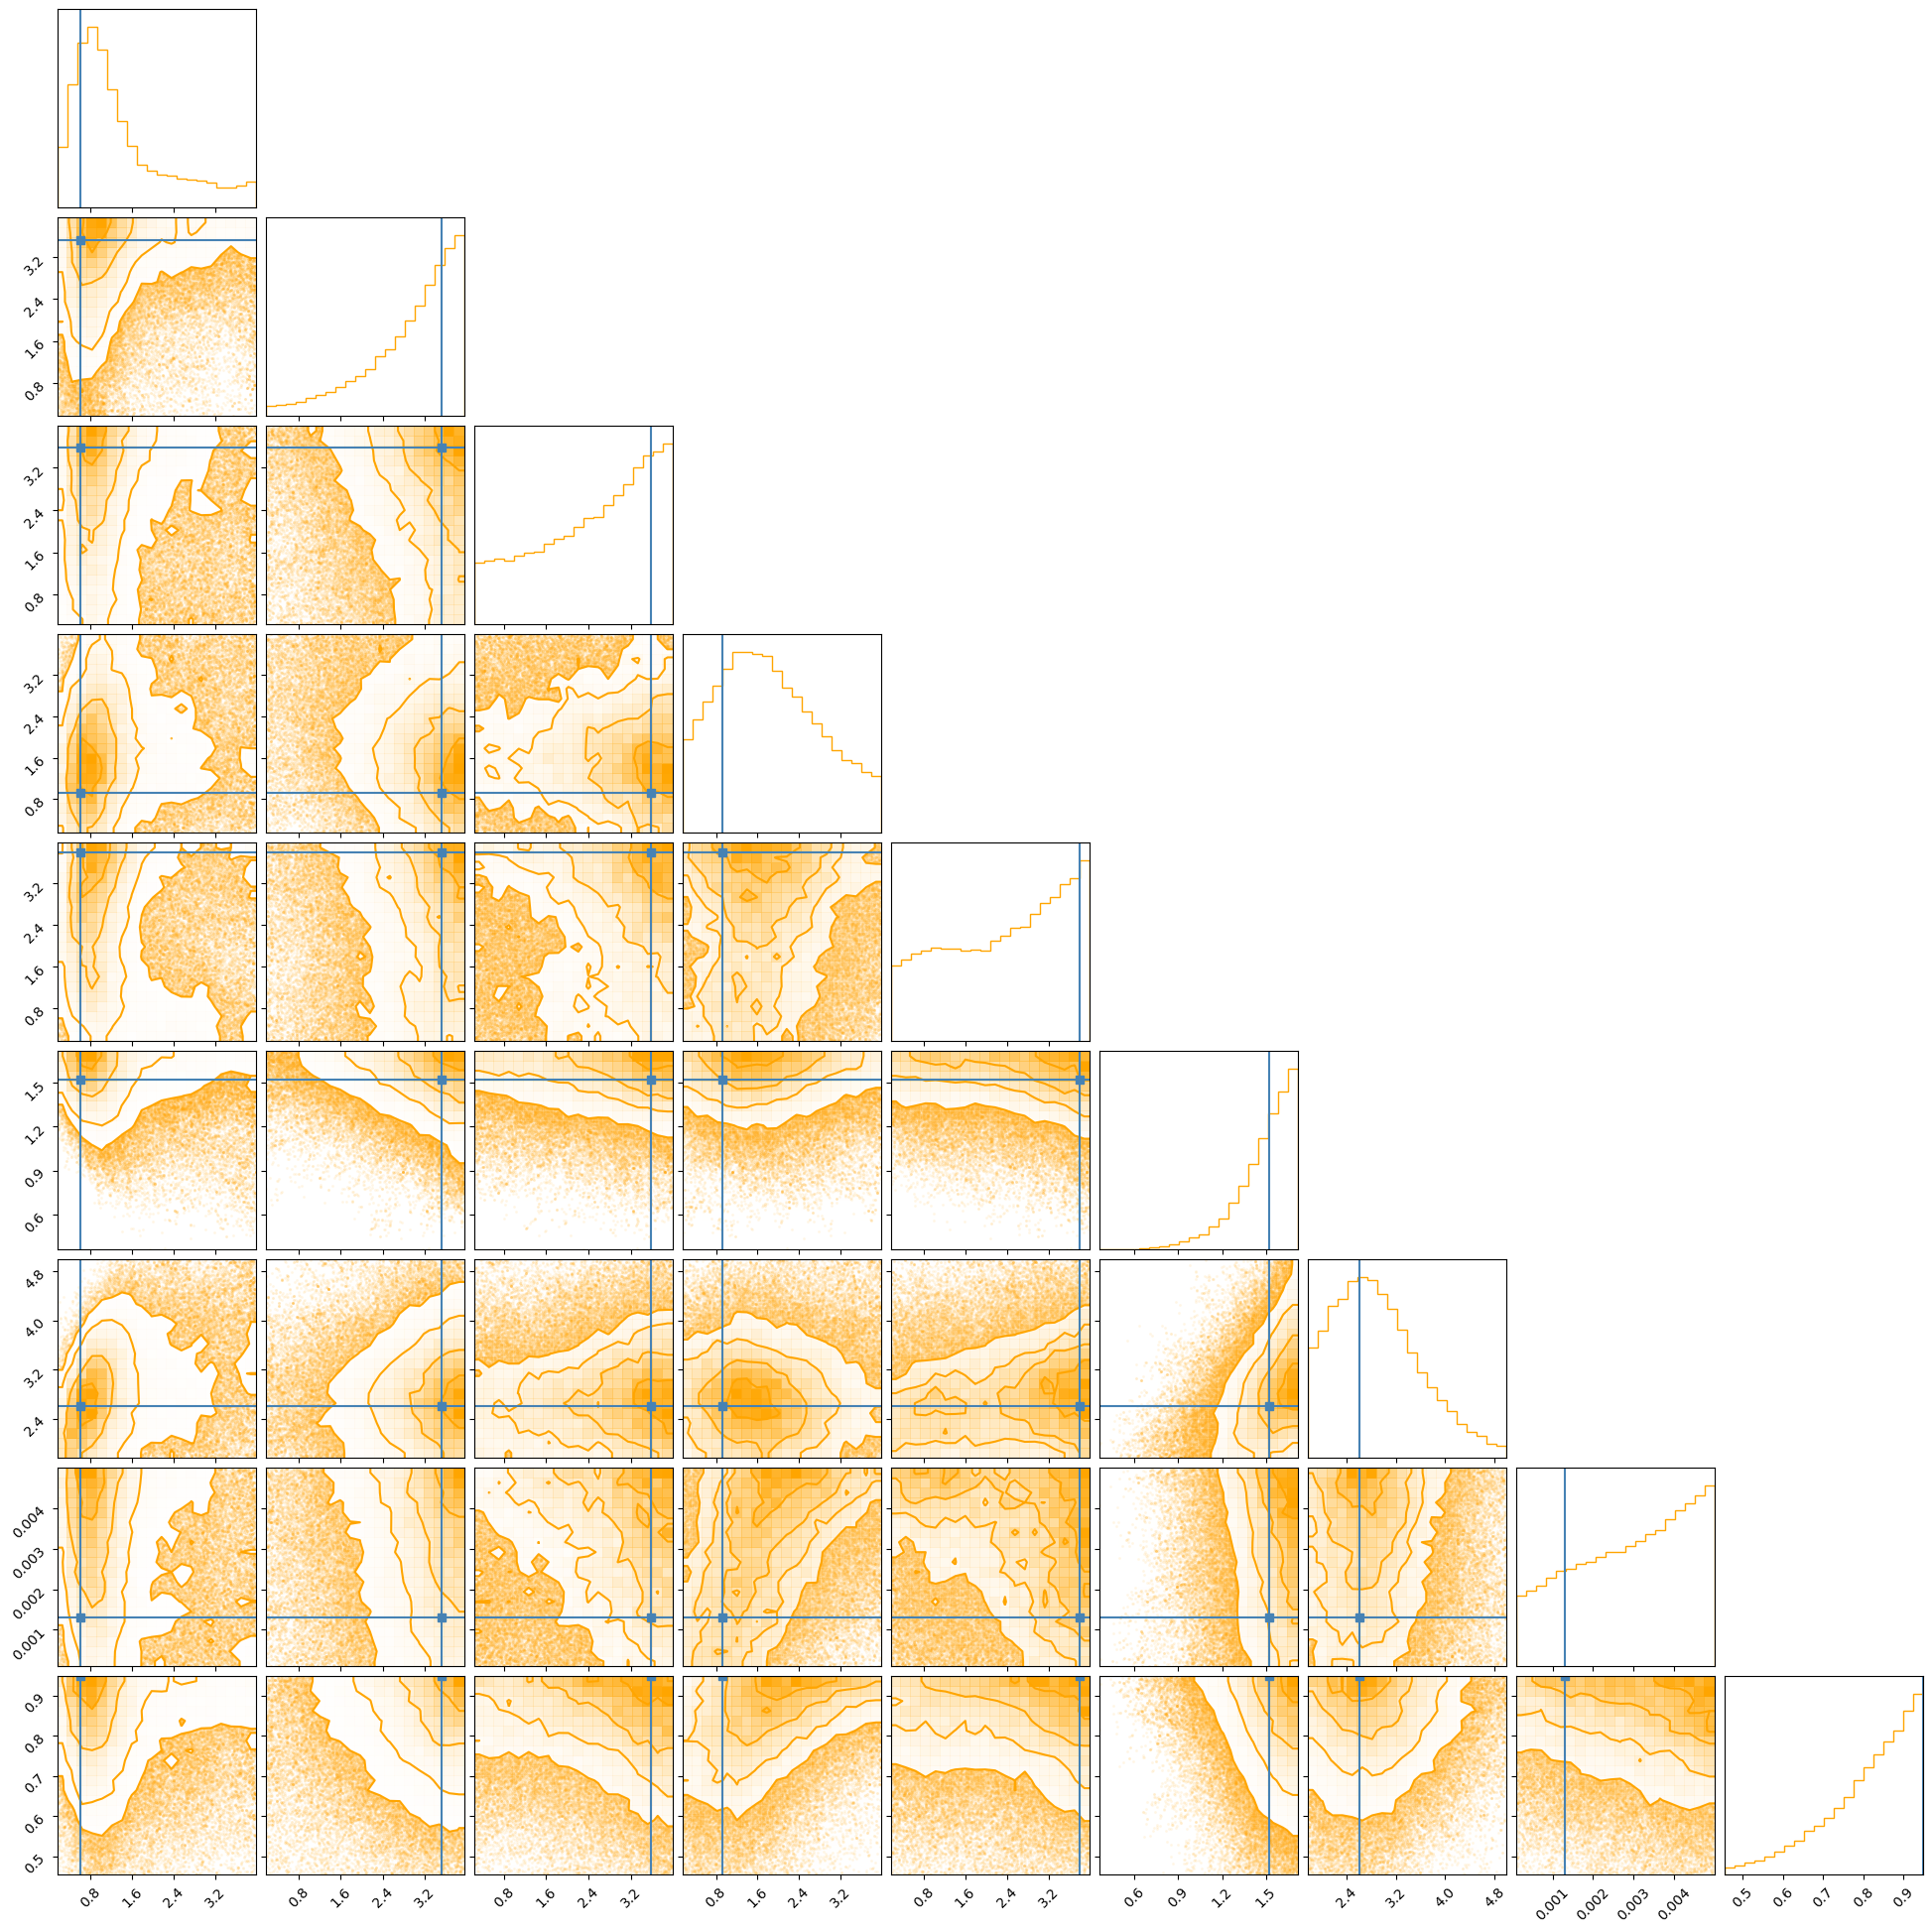

In [39]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=x_train[100]
);

In [110]:
samp = pd.DataFrame(flat_samples).sample(50)

In [111]:
samp.to_csv("MCMC_samples_scenario_6_80_2timesUpper.dat", sep = " ",index=False,header=None)

In [112]:
flat_samples.mean(axis=0)

array([1.36648291e+00, 2.88836322e+00, 2.53285288e+00, 1.85588233e+00,
       2.29060011e+00, 1.47170308e+00, 2.93095235e+00, 2.90001197e-03,
       8.10833408e-01])

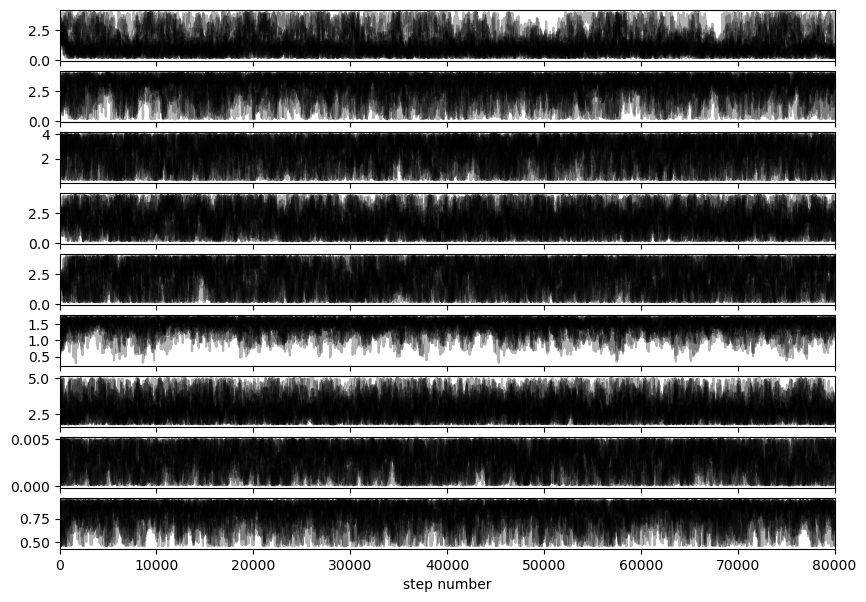

In [113]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [114]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [115]:
X_all.iloc[100]

0    0.5942
1    3.5308
2    3.5913
3    0.9272
4    3.8032
5    1.5238
6    2.6006
7    0.0013
8    0.9480
Name: 100, dtype: float64

In [116]:
emulator.predict(x_out[None,:])

tensor([[ 4.0796,  2.9090,  6.2187,  4.6553,  6.2341,  2.3607, 80.7796]],
       grad_fn=<PermuteBackward0>)

In [117]:
x_all=torch.tensor(X_all.values)

In [118]:
y_all=torch.tensor(y_all.values)


In [119]:
y_test = y_all[45,:]
x_test = x_all[45,:]

y_train = y_all[~torch.all(y_all == y_test, dim=1)]
x_train = x_all[~torch.all(x_all == x_test, dim=1)]

In [53]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8


In [59]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_test])

In [60]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-568.4171142578125
-568.3931274414062
-568.4723510742188
-568.4154663085938
-568.3650512695312
-568.4390869140625
-568.4057006835938
-568.4762573242188
-568.4352416992188
-568.38623046875
-568.406982421875
-568.3898315429688
-568.3843383789062
-568.4481811523438
-568.3812255859375
-568.427001953125


In [61]:
sampler.run_mcmc(p0, 40000)

State([[2.65088863e+00 2.50669425e+00 7.76869813e-01 7.77772516e-01
  3.99027792e+00 2.55262341e-01 3.19527448e+00 3.71071114e-03
  6.58219718e-01]
 [2.47234898e+00 2.55035739e+00 6.35560139e-01 7.34447489e-01
  4.12743766e+00 1.54625756e-01 3.15947561e+00 4.78323879e-03
  6.88468251e-01]
 [2.51607397e+00 2.60864724e+00 7.67916168e-01 5.58069294e-01
  4.07441079e+00 2.65793908e-01 3.17575002e+00 5.13065588e-03
  6.14037431e-01]
 [2.56888121e+00 2.60619714e+00 7.46119672e-01 7.65909933e-01
  3.91862480e+00 2.04184050e-01 3.22704572e+00 2.91848453e-03
  6.33138907e-01]
 [2.55852647e+00 2.61029351e+00 8.81704623e-01 6.57817629e-01
  3.97031343e+00 7.79893919e-02 3.10312299e+00 5.17166317e-03
  7.70374898e-01]
 [2.55251055e+00 2.70563430e+00 7.18950917e-01 6.19734132e-01
  3.78322193e+00 1.95210999e-01 3.25271248e+00 4.92145342e-03
  6.53146323e-01]
 [2.50191223e+00 2.51225408e+00 7.22244181e-01 8.71988893e-01
  3.89036613e+00 1.74477336e-01 3.16652249e+00 3.89175627e-03
  7.47362378e-01]


In [62]:
flat_samples = sampler.get_chain(discard=8000, thin=1, flat=True)
print(flat_samples.shape)

(576000, 9)


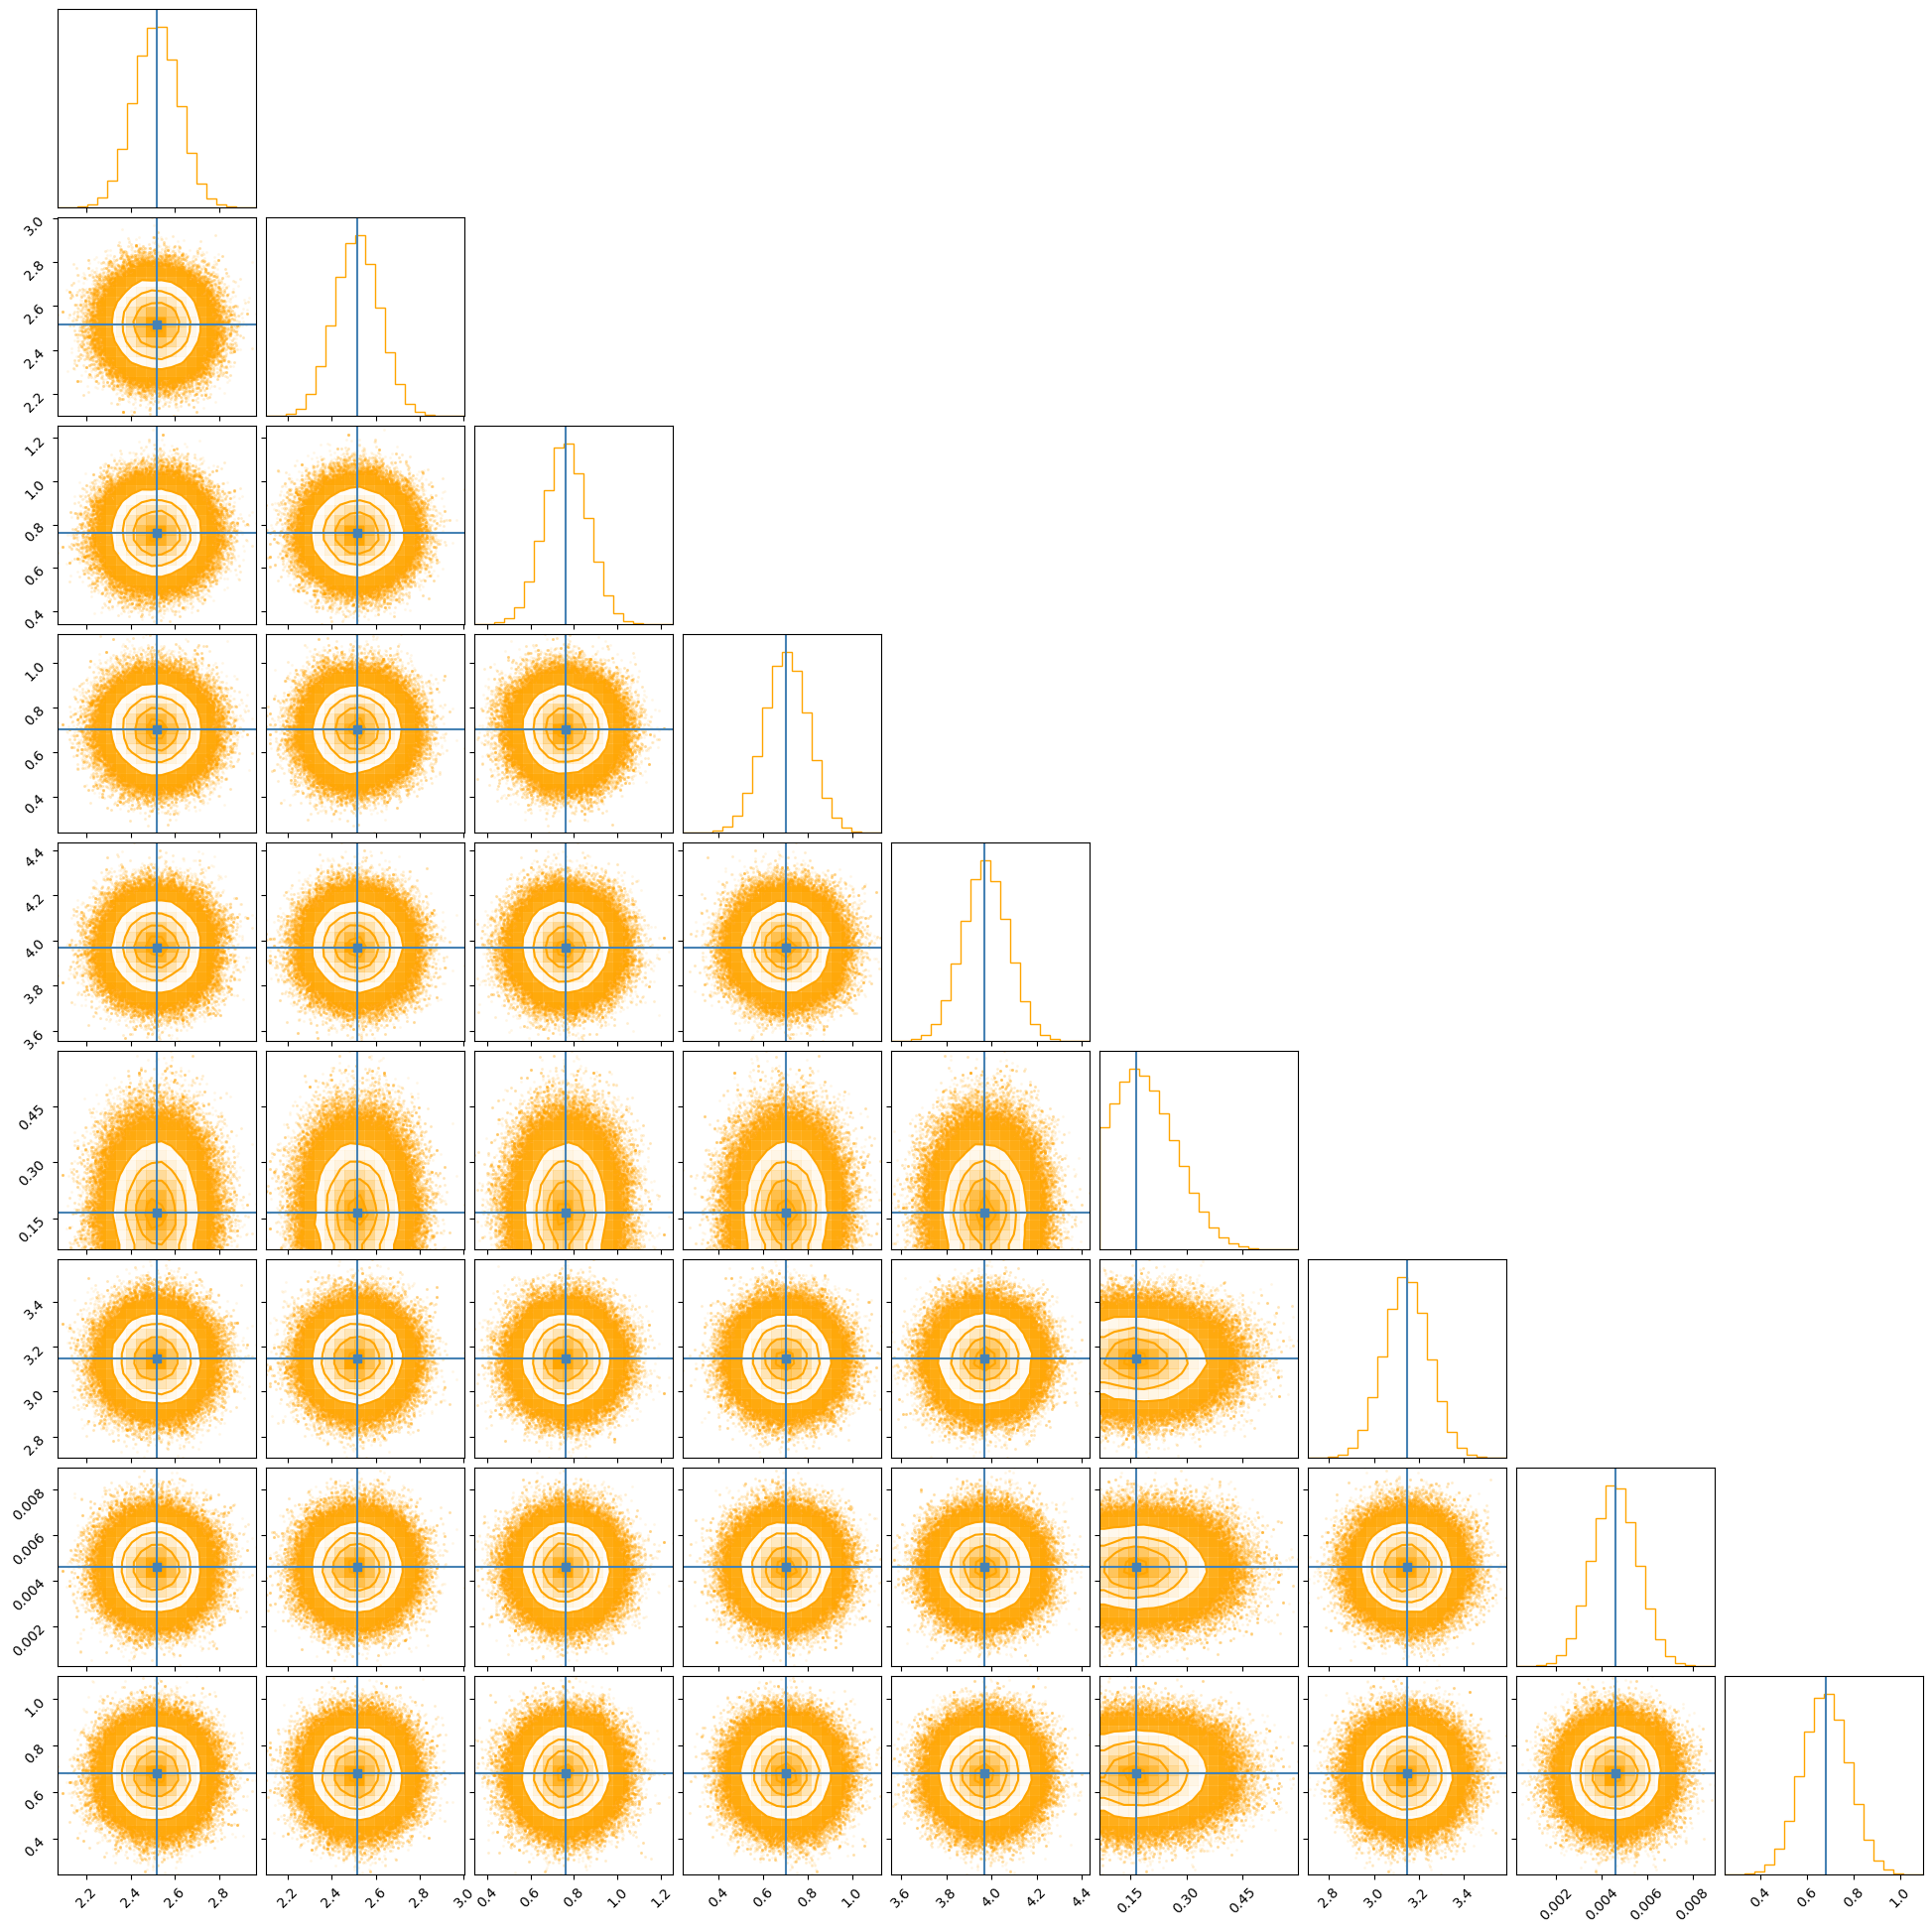

In [63]:
import corner

fig = corner.corner(
    flat_samples, label_kwargs=dict(fontsize=18),color='orange',truths=y_test
);